# Modelo XGBoost para Predicción de Potencia en Granjas Undimotrices

Este notebook implementa el modelo completo:
- Preprocesamiento de datos
- Ordenamiento canónico (solución a invarianza de permutación)
- Ingeniería de características
- Entrenamiento de XGBoost
- Evaluación y métricas


In [31]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Optimización Bayesiana con Optuna
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Optuna no está instalado. Instala con: pip install optuna")
    OPTUNA_AVAILABLE = False
    # Fallback a RandomizedSearchCV si Optuna no está disponible
    from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Directorios
DATASET_DIR = Path("dataset")
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

print("Librerías importadas correctamente")


Librerías importadas correctamente


## 1. Clase de Ingeniería de Características


In [32]:
class FeatureEngineer:
    """Clase para ingeniería de características con ordenamiento canónico."""

    def __init__(self, n_converters):
        self.n_converters = n_converters

    def canonical_ordering(self, coordinates):
        """
        Ordenamiento canónico: ordenar por X (ascendente), luego Y (ascendente).
        Resuelve el problema de invarianza de permutación.

        Args:
            coordinates: array de shape (n_samples, n_converters, 2) con [X, Y]

        Returns:
            coordinates_ordered: coordenadas ordenadas canónicamente
        """
        n_samples = coordinates.shape[0]
        coordinates_ordered = np.zeros_like(coordinates)

        for i in range(n_samples):
            coords = coordinates[i].copy()
            # Ordenar lexicográficamente: primero por X, luego por Y
            sort_indices = np.lexsort((coords[:, 1], coords[:, 0]))
            coordinates_ordered[i] = coords[sort_indices]

        return coordinates_ordered

    def extract_coordinates(self, df):
        """Extrae coordenadas X, Y del dataframe."""
        x_cols = [f'X{i+1}' for i in range(self.n_converters)]
        y_cols = [f'Y{i+1}' for i in range(self.n_converters)]

        x_values = df[x_cols].values
        y_values = df[y_cols].values

        # Reshape a (n_samples, n_converters, 2)
        coordinates = np.stack([x_values, y_values], axis=2)
        return coordinates

    def compute_centroid(self, coordinates):
        """Calcula el centroide de cada configuración."""
        return coordinates.mean(axis=1)

    def compute_distances_to_centroid(self, coordinates, centroids):
        """Calcula distancia de cada WEC al centroide."""
        n_samples = coordinates.shape[0]
        distances = np.zeros((n_samples, self.n_converters))

        for i in range(n_samples):
            centroid = centroids[i]
            coords = coordinates[i]
            distances[i] = np.sqrt(np.sum((coords - centroid)**2, axis=1))

        return distances

    def compute_neighbor_distances(self, coordinates, k=3):
        """Calcula distancia a los k vecinos más cercanos."""
        n_samples = coordinates.shape[0]
        min_distances = np.zeros((n_samples, self.n_converters))
        mean_distances = np.zeros((n_samples, self.n_converters))

        for i in range(n_samples):
            coords = coordinates[i]

            for j in range(self.n_converters):
                distances = np.sqrt(np.sum((coords - coords[j])**2, axis=1))
                distances[j] = np.inf  # Excluir distancia a sí mismo

                k_nearest = np.partition(distances, min(k, len(distances)-1))[:k+1]
                k_nearest = k_nearest[k_nearest != np.inf]

                if len(k_nearest) > 0:
                    min_distances[i, j] = np.min(k_nearest)
                    mean_distances[i, j] = np.mean(k_nearest[:k])

        return min_distances, mean_distances

    def compute_spatial_metrics(self, coordinates):
        """Calcula métricas de dispersión espacial."""
        n_samples = coordinates.shape[0]
        metrics = {
            'max_distance': np.zeros(n_samples),
            'min_distance': np.zeros(n_samples),
            'mean_distance': np.zeros(n_samples),
            'std_distance': np.zeros(n_samples)
        }

        for i in range(n_samples):
            coords = coordinates[i]
            distances = []
            for j in range(self.n_converters):
                for k in range(j+1, self.n_converters):
                    dist = np.linalg.norm(coords[j] - coords[k])
                    distances.append(dist)

            if distances:
                distances = np.array(distances)
                metrics['max_distance'][i] = np.max(distances)
                metrics['min_distance'][i] = np.min(distances)
                metrics['mean_distance'][i] = np.mean(distances)
                metrics['std_distance'][i] = np.std(distances)

        return metrics

    def compute_shadowing_index(self, coordinates, wave_direction='left', y_bandwidth=50.0):
        """
        Calcula el índice de sombra (shadowing) basado en la dirección de las olas.
        
        Si las olas vienen de la izquierda (X negativo), cuenta cuántos WECs están
        "aguas arriba" (con X menor) de cada WEC, dentro de un ancho de banda en Y.
        
        Args:
            coordinates: array (n_samples, n_converters, 2) con coordenadas ordenadas
            wave_direction: 'left' (olas desde X negativo) o 'right' (olas desde X positivo)
            y_bandwidth: ancho de banda en Y para considerar vecinos "en frente"
        
        Returns:
            shadowing_index: array (n_samples, n_converters) con conteo de WECs aguas arriba
        """
        n_samples = coordinates.shape[0]
        shadowing_index = np.zeros((n_samples, self.n_converters))
        
        for i in range(n_samples):
            coords = coordinates[i]  # (n_converters, 2)
            
            for j in range(self.n_converters):
                current_x = coords[j, 0]
                current_y = coords[j, 1]
                
                # Contar WECs "aguas arriba" según dirección de olas
                upstream_count = 0
                for k in range(self.n_converters):
                    if k == j:
                        continue
                    
                    other_x = coords[k, 0]
                    other_y = coords[k, 1]
                    
                    # Verificar si está dentro del ancho de banda en Y
                    y_distance = abs(other_y - current_y)
                    if y_distance > y_bandwidth:
                        continue
                    
                    # Verificar si está aguas arriba según dirección
                    if wave_direction == 'left':
                        # Olas desde izquierda: aguas arriba = X menor
                        if other_x < current_x:
                            upstream_count += 1
                    elif wave_direction == 'right':
                        # Olas desde derecha: aguas arriba = X mayor
                        if other_x > current_x:
                            upstream_count += 1
                
                shadowing_index[i, j] = upstream_count
        
        return shadowing_index

    def transform(self, df):
        """
        Transforma el dataframe aplicando todas las transformaciones.

        Returns:
            X: array de features (n_samples, n_features)
            y: array de target (n_samples,)
            feature_names: lista de nombres de features
        """
        # Extraer coordenadas
        coordinates = self.extract_coordinates(df)

        # Aplicar ordenamiento canónico (CRÍTICO)
        coordinates = self.canonical_ordering(coordinates)

        # Aplanar coordenadas ordenadas
        n_samples = coordinates.shape[0]
        X_coords = coordinates.reshape(n_samples, -1)

        # Nombres de features de coordenadas
        coord_feature_names = []
        for i in range(self.n_converters):
            coord_feature_names.append(f'X{i+1}_ordered')
            coord_feature_names.append(f'Y{i+1}_ordered')

        X_list = [X_coords]
        feature_names_list = [coord_feature_names]

        # Features de ingeniería
        centroids = self.compute_centroid(coordinates)
        dist_to_centroid = self.compute_distances_to_centroid(coordinates, centroids)
        min_dist, mean_dist = self.compute_neighbor_distances(coordinates, k=3)
        spatial_metrics = self.compute_spatial_metrics(coordinates)
        
        # Shadowing Index (efecto sombra basado en dirección de olas)
        # Asumimos olas desde la izquierda (X negativo) por defecto
        shadowing_index = self.compute_shadowing_index(coordinates, wave_direction='left', y_bandwidth=50.0)

        X_list.extend([
            dist_to_centroid,
            min_dist,
            mean_dist,
            np.column_stack([
                spatial_metrics['max_distance'],
                spatial_metrics['min_distance'],
                spatial_metrics['mean_distance'],
                spatial_metrics['std_distance']
            ]),
            shadowing_index  # Agregar shadowing index
        ])

        feature_names_list.extend([
            [f'dist_centroid_{i+1}' for i in range(self.n_converters)],
            [f'min_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            [f'mean_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            ['max_distance', 'min_distance', 'mean_distance', 'std_distance'],
            [f'shadowing_index_{i+1}' for i in range(self.n_converters)]  # Shadowing index por WEC
        ])

        # Concatenar todas las features
        X = np.hstack(X_list)
        feature_names = [name for sublist in feature_names_list for name in sublist]

        # Extraer target
        y = df['Total_Power'].values

        return X, y, feature_names

print("Clase FeatureEngineer definida")



Clase FeatureEngineer definida


## 2. Carga y Preprocesamiento de Datos


In [33]:
# Configuración del dataset a procesar
DATASET_NAME = "sydney_49"# Cambiar a "sydney_49", "perth_100", "sydney_100"según necesidad

# Mapeo de nombres a archivos
dataset_files = {
 "perth_49": "WEC_Perth_49.csv",
 "perth_100": "WEC_Perth_100.csv",
 "sydney_49": "WEC_Sydney_49.csv",
 "sydney_100": "WEC_Sydney_100.csv"
}
DATASET_FILE = DATASET_DIR / dataset_files[DATASET_NAME]

# Determinar número de convertidores
if "49"in DATASET_NAME:
 N_CONVERTERS = 49
else:
 N_CONVERTERS = 100

print(f"Dataset: {DATASET_NAME}")
print(f"Archivo: {DATASET_FILE}")
print(f"Convertidores: {N_CONVERTERS}")

# Cargar datos
df = pd.read_csv(DATASET_FILE)
print(f"Datos cargados: {len(df):,} filas × {len(df.columns)} columnas")

# Eliminar duplicados
df_original = len(df)
df = df.drop_duplicates()
print(f"Duplicados eliminados: {df_original - len(df):,} filas")
print(f"Filas únicas: {len(df):,}")


Dataset: sydney_49
Archivo: dataset\WEC_Sydney_49.csv
Convertidores: 49


Datos cargados: 17,964 filas × 149 columnas
Duplicados eliminados: 13,148 filas
Filas únicas: 4,816


In [34]:
# Aplicar ingeniería de características
fe = FeatureEngineer(N_CONVERTERS)
X, y, feature_names = fe.transform(df)

print(f"Ingeniería de características completada")
print(f"Features generadas: {len(feature_names)}")
print(f"Shape: X={X.shape}, y={y.shape}")
print(f"Primeras 10 features: {feature_names[:10]}")
print(f"Últimas 5 features: {feature_names[-5:]}")

# Estadísticas
print(f"Estadísticas de X:")
print(f"Min: {X.min():.2f}, Max: {X.max():.2f}")
print(f"Mean: {X.mean():.2f}, Std: {X.std():.2f}")
print(f"Estadísticas de y (Total_Power):")
print(f"Min: {y.min():.2f}, Max: {y.max():.2f}")
print(f"Mean: {y.mean():.2f}, Std: {y.std():.2f}")


Ingeniería de características completada
Features generadas: 298
Shape: X=(4816, 298), y=(4816,)
Primeras 10 features: ['X1_ordered', 'Y1_ordered', 'X2_ordered', 'Y2_ordered', 'X3_ordered', 'Y3_ordered', 'X4_ordered', 'Y4_ordered', 'X5_ordered', 'Y5_ordered']
Últimas 5 features: ['shadowing_index_45', 'shadowing_index_46', 'shadowing_index_47', 'shadowing_index_48', 'shadowing_index_49']
Estadísticas de X:
Min: 0.00, Max: 1421.30
Mean: 283.40, Std: 305.17
Estadísticas de y (Total_Power):
Min: 3625434.37, Max: 4145252.22
Mean: 3985541.81, Std: 80562.33


## 3. División Train/Validation/Test


## Opciones de Entrenamiento

A continuación hay dos opciones:

**Opción A (Sección 4-5)**: Entrenar un modelo para el dataset configurado en `DATASET_NAME`
- Útil para exploración, pruebas y desarrollo
- Permite ver resultados detallados de un dataset

**Opción B (Sección 6)**: Entrenar modelos para TODOS los datasets en paralelo
- Útil para producción y entrenamiento completo
- Más eficiente, entrena todos los modelos a la vez
- Usa hiperparámetros optimizados para reducir overfitting

**Recomendación**: Si quieres entrenar todos los modelos, ve directamente a la Sección 6.

In [35]:
# División train/val/test para entrenamiento individual (70% train / 15% val / 15% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42  # 15% del total
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"División de datos:")
print(f"  Train: {len(X_train):,} muestras")
print(f"  Validation: {len(X_val):,} muestras")
print(f"  Test: {len(X_test):,} muestras")
print(f"\nDatos normalizados")


División de datos:
  Train: 3,370 muestras
  Validation: 723 muestras
  Test: 723 muestras

Datos normalizados


## 6. Entrenamiento Paralelo para Todos los Datasets

Esta sección entrena modelos para todos los datasets en paralelo con hiperparámetros optimizados para reducir overfitting.

In [36]:
from joblib import Parallel, delayed
import time
from pathlib import Path
from sklearn.model_selection import cross_val_score

def train_model_for_dataset(dataset_name):
    """
    Entrena un modelo XGBoost para un dataset específico.
    
    Args:
        dataset_name: nombre del dataset ('perth_49', 'sydney_49', 'perth_100', 'sydney_100')
    
    Returns:
        dict: resultados del entrenamiento
    """
    # Importar módulos necesarios (para ejecución paralela)
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import xgboost as xgb
    import pickle
    import time
    
    # Verificar disponibilidad de Optuna
    try:
        import optuna
        OPTUNA_AVAILABLE_LOCAL = True
    except ImportError:
        OPTUNA_AVAILABLE_LOCAL = False
        from sklearn.model_selection import RandomizedSearchCV
    
    # Definir clase FeatureEngineer dentro de la función (para serialización en paralelo)
    class FeatureEngineer:
        """Clase para ingeniería de características con ordenamiento canónico."""

        def __init__(self, n_converters):
            self.n_converters = n_converters

        def canonical_ordering(self, coordinates):
            """Ordenamiento canónico: ordenar por X (ascendente), luego Y (ascendente)."""
            n_samples = coordinates.shape[0]
            coordinates_ordered = np.zeros_like(coordinates)

            for i in range(n_samples):
                coords = coordinates[i].copy()
                sort_indices = np.lexsort((coords[:, 1], coords[:, 0]))
                coordinates_ordered[i] = coords[sort_indices]

            return coordinates_ordered

        def extract_coordinates(self, df):
            """Extrae coordenadas X, Y del dataframe."""
            x_cols = [f'X{i+1}' for i in range(self.n_converters)]
            y_cols = [f'Y{i+1}' for i in range(self.n_converters)]

            x_values = df[x_cols].values
            y_values = df[y_cols].values

            coordinates = np.stack([x_values, y_values], axis=2)
            return coordinates

        def compute_centroid(self, coordinates):
            """Calcula el centroide de cada configuración."""
            return coordinates.mean(axis=1)

        def compute_distances_to_centroid(self, coordinates, centroids):
            """Calcula distancia de cada WEC al centroide."""
            n_samples = coordinates.shape[0]
            distances = np.zeros((n_samples, self.n_converters))

            for i in range(n_samples):
                centroid = centroids[i]
                coords = coordinates[i]
                distances[i] = np.sqrt(np.sum((coords - centroid)**2, axis=1))

            return distances

        def compute_neighbor_distances(self, coordinates, k=3):
            """Calcula distancia a los k vecinos más cercanos."""
            n_samples = coordinates.shape[0]
            min_distances = np.zeros((n_samples, self.n_converters))
            mean_distances = np.zeros((n_samples, self.n_converters))

            for i in range(n_samples):
                coords = coordinates[i]

                for j in range(self.n_converters):
                    distances = np.sqrt(np.sum((coords - coords[j])**2, axis=1))
                    distances[j] = np.inf

                    k_nearest = np.partition(distances, min(k, len(distances)-1))[:k+1]
                    k_nearest = k_nearest[k_nearest != np.inf]

                    if len(k_nearest) > 0:
                        min_distances[i, j] = np.min(k_nearest)
                        mean_distances[i, j] = np.mean(k_nearest[:k])

            return min_distances, mean_distances

        def compute_spatial_metrics(self, coordinates):
            """Calcula métricas de dispersión espacial."""
            n_samples = coordinates.shape[0]
            metrics = {
                'max_distance': np.zeros(n_samples),
                'min_distance': np.zeros(n_samples),
                'mean_distance': np.zeros(n_samples),
                'std_distance': np.zeros(n_samples)
            }

            for i in range(n_samples):
                coords = coordinates[i]
                distances = []
                for j in range(self.n_converters):
                    for k in range(j+1, self.n_converters):
                        dist = np.linalg.norm(coords[j] - coords[k])
                        distances.append(dist)

                if distances:
                    distances = np.array(distances)
                    metrics['max_distance'][i] = np.max(distances)
                    metrics['min_distance'][i] = np.min(distances)
                    metrics['mean_distance'][i] = np.mean(distances)
                    metrics['std_distance'][i] = np.std(distances)

            return metrics

        def compute_shadowing_index(self, coordinates, wave_direction='left', y_bandwidth=50.0):
            """Calcula el índice de sombra (shadowing) basado en la dirección de las olas."""
            n_samples = coordinates.shape[0]
            shadowing_index = np.zeros((n_samples, self.n_converters))
            
            for i in range(n_samples):
                coords = coordinates[i]
                
                for j in range(self.n_converters):
                    current_x = coords[j, 0]
                    current_y = coords[j, 1]
                    
                    upstream_count = 0
                    for k in range(self.n_converters):
                        if k == j:
                            continue
                        
                        other_x = coords[k, 0]
                        other_y = coords[k, 1]
                        
                        y_distance = abs(other_y - current_y)
                        if y_distance > y_bandwidth:
                            continue
                        
                        if wave_direction == 'left':
                            if other_x < current_x:
                                upstream_count += 1
                        elif wave_direction == 'right':
                            if other_x > current_x:
                                upstream_count += 1
                    
                    shadowing_index[i, j] = upstream_count
            
            return shadowing_index

        def transform(self, df):
            """Transforma el dataframe aplicando todas las transformaciones."""
            coordinates = self.extract_coordinates(df)
            coordinates = self.canonical_ordering(coordinates)

            n_samples = coordinates.shape[0]
            X_coords = coordinates.reshape(n_samples, -1)

            coord_feature_names = []
            for i in range(self.n_converters):
                coord_feature_names.append(f'X{i+1}_ordered')
                coord_feature_names.append(f'Y{i+1}_ordered')

            X_list = [X_coords]
            feature_names_list = [coord_feature_names]

            centroids = self.compute_centroid(coordinates)
            dist_to_centroid = self.compute_distances_to_centroid(coordinates, centroids)
            min_dist, mean_dist = self.compute_neighbor_distances(coordinates, k=3)
            spatial_metrics = self.compute_spatial_metrics(coordinates)
            shadowing_index = self.compute_shadowing_index(coordinates, wave_direction='left', y_bandwidth=50.0)

            X_list.extend([
                dist_to_centroid,
                min_dist,
                mean_dist,
                np.column_stack([
                    spatial_metrics['max_distance'],
                    spatial_metrics['min_distance'],
                    spatial_metrics['mean_distance'],
                    spatial_metrics['std_distance']
                ]),
                shadowing_index
            ])

            feature_names_list.extend([
                [f'dist_centroid_{i+1}' for i in range(self.n_converters)],
                [f'min_dist_neighbor_{i+1}' for i in range(self.n_converters)],
                [f'mean_dist_neighbor_{i+1}' for i in range(self.n_converters)],
                ['max_distance', 'min_distance', 'mean_distance', 'std_distance'],
                [f'shadowing_index_{i+1}' for i in range(self.n_converters)]
            ])

            X = np.hstack(X_list)
            feature_names = [name for sublist in feature_names_list for name in sublist]
            y = df['Total_Power'].values

            return X, y, feature_names
    
    # Definir función de optimización dentro de la función (para serialización en paralelo)
    def optimize_xgboost_with_optuna(X_train, y_train, X_val, y_val, n_trials=50, timeout=None):
        """Optimiza hiperparámetros de XGBoost usando Optuna."""
        if not OPTUNA_AVAILABLE_LOCAL:
            from sklearn.model_selection import RandomizedSearchCV
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.05, 0.1],
                'subsample': [0.7, 0.8],
                'reg_alpha': [0.1, 1.0, 10.0],
                'reg_lambda': [1.0, 10.0, 100.0],
                'min_child_weight': [3, 5]
            }
            print("Usando RandomizedSearchCV (fallback, Optuna no disponible)")
            xgb_model = RandomizedSearchCV(
                xgb.XGBRegressor(random_state=42, n_jobs=-1),
                param_grid,
                n_iter=50,
                cv=3,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0,
                random_state=42
            )
            xgb_model.fit(X_train, y_train)
            return xgb_model.best_estimator_, xgb_model.best_params_
        
        def objective(trial):
            """Función objetivo para Optuna."""
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 100.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 100.0, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'random_state': 42,
                'n_jobs': -1
            }
            
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            return mse
        
        print(f"Optimizando con Optuna ({n_trials} trials)...")
        study = optuna.create_study(direction='minimize', study_name='xgboost_optimization')
        study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
        
        best_params = study.best_params
        best_params['random_state'] = 42
        best_params['n_jobs'] = -1
        
        print(f"Mejores parámetros encontrados:")
        for key, value in best_params.items():
            if key not in ['random_state', 'n_jobs']:
                print(f"  {key}: {value}")
        print(f"  Mejor MSE: {study.best_value:.2f}")
        
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(X_train, y_train)
        
        return best_model, best_params
    
    # Definir función de métricas (necesaria para ejecución paralela)
    def calculate_metrics(y_true, y_pred):
        """Calcula todas las métricas de evaluación."""
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        return {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
    
    print(f"\n{'='*70}")
    print(f"Procesando: {dataset_name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    try:
        
        # Directorios (definir localmente para ejecución paralela)
        DATASET_DIR = Path("dataset")
        MODELS_DIR = Path("models")
        MODELS_DIR.mkdir(exist_ok=True)
        
        # Configuración del dataset
        dataset_files = {
            "perth_49": "WEC_Perth_49.csv",
            "perth_100": "WEC_Perth_100.csv",
            "sydney_49": "WEC_Sydney_49.csv",
            "sydney_100": "WEC_Sydney_100.csv"
        }
        
        DATASET_FILE = DATASET_DIR / dataset_files[dataset_name]
        
        # Determinar número de convertidores
        if "49" in dataset_name:
            N_CONVERTERS = 49
        else:
            N_CONVERTERS = 100
        
        print(f"Dataset: {dataset_name}")
        print(f"Archivo: {DATASET_FILE}")
        print(f"Convertidores: {N_CONVERTERS}")
        
        # Cargar datos
        df = pd.read_csv(DATASET_FILE)
        df_original = len(df)
        df = df.drop_duplicates()
        print(f"Datos cargados: {df_original:,} filas × {len(df.columns)} columnas")
        print(f"Duplicados eliminados: {df_original - len(df):,} filas")
        print(f"Filas únicas: {len(df):,}")
        
        # Feature engineering
        # FeatureEngineer está definido dentro de esta función para serialización en paralelo
        fe = FeatureEngineer(N_CONVERTERS)
        X, y, feature_names = fe.transform(df)
        print(f"Features generadas: {len(feature_names)}")
        
        # División train/val/test (60/20/20)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 del total
        )
        
        # Normalización
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Optimización Bayesiana con Optuna (más eficiente que GridSearch/RandomizedSearch)
        print(f"\nOptimizando hiperparámetros con Optuna...")
        best_model, best_params = optimize_xgboost_with_optuna(
            X_train_scaled, y_train, 
            X_val_scaled, y_val,
            n_trials=50,  # Número de trials (equivalente a n_iter en RandomizedSearch)
            timeout=None  # Sin límite de tiempo
        )
        
        # Evaluación
        y_pred_train = best_model.predict(X_train_scaled)
        y_pred_val = best_model.predict(X_val_scaled)
        y_pred_test = best_model.predict(X_test_scaled)
        
        metrics_train = calculate_metrics(y_train, y_pred_train)
        metrics_val = calculate_metrics(y_val, y_pred_val)
        metrics_test = calculate_metrics(y_test, y_pred_test)
        
        # Mostrar resultados
        print(f"\n{'='*70}")
        print(f"RESULTADOS - {dataset_name.upper()}")
        print(f"{'='*70}")
        print(f"Train Set:")
        print(f"  RMSE: {metrics_train['RMSE']:.2f} W")
        print(f"  MAE: {metrics_train['MAE']:.2f} W")
        print(f"  R²: {metrics_train['R2']:.4f}")
        print(f"  MAPE: {metrics_train['MAPE']:.2f}%")
        print(f"\nValidation Set:")
        print(f"  RMSE: {metrics_val['RMSE']:.2f} W")
        print(f"  MAE: {metrics_val['MAE']:.2f} W")
        print(f"  R²: {metrics_val['R2']:.4f}")
        print(f"  MAPE: {metrics_val['MAPE']:.2f}%")
        print(f"\nTest Set:")
        print(f"  RMSE: {metrics_test['RMSE']:.2f} W")
        print(f"  MAE: {metrics_test['MAE']:.2f} W")
        print(f"  R²: {metrics_test['R2']:.4f}")
        print(f"  MAPE: {metrics_test['MAPE']:.2f}%")
        
        # Calcular gap de overfitting
        overfitting_gap = metrics_train['RMSE'] / metrics_test['RMSE'] if metrics_test['RMSE'] > 0 else 0
        print(f"\nGap Train/Test RMSE: {overfitting_gap:.2f}x")
        
        # Guardar modelo
        model_data = {
            'model': best_model,
            'scaler': scaler,
            'feature_engineer': fe,
            'feature_names': feature_names,
            'n_converters': N_CONVERTERS,
            'dataset_name': dataset_name,
            'best_params': best_params,
            'metrics': {
                'train': metrics_train,
                'val': metrics_val,
                'test': metrics_test
            },
            'overfitting_gap': overfitting_gap
        }
        
        model_file = MODELS_DIR / f"modelo_xgboost_{dataset_name}.pkl"
        with open(model_file, 'wb') as f:
            pickle.dump(model_data, f)
        
        elapsed_time = time.time() - start_time
        print(f"\nModelo guardado en: {model_file}")
        print(f"Tiempo de entrenamiento: {elapsed_time/60:.2f} minutos")
        
        return {
            'dataset': dataset_name,
            'metrics': {
                'train': metrics_train,
                'val': metrics_val,
                'test': metrics_test
            },
            'overfitting_gap': overfitting_gap,
            'time': elapsed_time,
            'best_params': best_params
        }
        
    except Exception as e:
        print(f"\nERROR procesando {dataset_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'dataset': dataset_name,
            'error': str(e)
        }


In [37]:
# Lista de datasets a procesar
datasets = ["perth_49", "sydney_49", "perth_100", "sydney_100"]

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO PARALELO DE {len(datasets)} DATASETS")
print(f"{'='*70}")
print(f"\nEstrategia:")
print(f"  - Paralelismo entre datasets: 2 workers (para evitar saturación de memoria)")
print(f"  - Paralelismo dentro de GridSearch: todos los cores disponibles")
print(f"  - Hiperparámetros optimizados para reducir overfitting")
print(f"  - Early stopping activado")

start_total = time.time()

# Entrenar en paralelo con joblib
# n_jobs=2 para evitar saturación de memoria (cada dataset puede ser grande)
results = Parallel(n_jobs=2, verbose=10)(
    delayed(train_model_for_dataset)(dataset) for dataset in datasets
)

elapsed_total = time.time() - start_total

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO COMPLETADO")
print(f"{'='*70}")
print(f"Tiempo total: {elapsed_total/60:.2f} minutos")
print(f"\nResumen de resultados:")
print(f"{'='*70}")

for result in results:
    if 'error' not in result:
        dataset = result['dataset']
        metrics = result['metrics']['test']
        gap = result['overfitting_gap']
        print(f"\n{dataset.upper()}:")
        print(f"  R² (test): {metrics['R2']:.4f}")
        print(f"  RMSE (test): {metrics['RMSE']:.2f} W")
        print(f"  MAPE (test): {metrics['MAPE']:.2f}%")
        print(f"  Overfitting gap: {gap:.2f}x")
        print(f"  Tiempo: {result['time']/60:.2f} min")
    else:
        print(f"\n{result['dataset'].upper()}: ERROR - {result['error']}")



ENTRENAMIENTO PARALELO DE 4 DATASETS

Estrategia:
  - Paralelismo entre datasets: 2 workers (para evitar saturación de memoria)
  - Paralelismo dentro de GridSearch: todos los cores disponibles
  - Hiperparámetros optimizados para reducir overfitting
  - Early stopping activado


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 11.1min
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed: 12.5min remaining: 12.5min



ENTRENAMIENTO COMPLETADO
Tiempo total: 27.99 minutos

Resumen de resultados:

PERTH_49: ERROR - Can't get local object 'train_model_for_dataset.<locals>.FeatureEngineer'

SYDNEY_49: ERROR - Can't get local object 'train_model_for_dataset.<locals>.FeatureEngineer'

PERTH_100: ERROR - Can't get local object 'train_model_for_dataset.<locals>.FeatureEngineer'

SYDNEY_100: ERROR - Can't get local object 'train_model_for_dataset.<locals>.FeatureEngineer'


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 28.0min finished


## 4. Entrenamiento de XGBoost


In [38]:
# Optimización Bayesiana con Optuna (más eficiente que GridSearch/RandomizedSearch)
print("Optimizando hiperparámetros con Optuna...")
best_model, best_params = optimize_xgboost_with_optuna(
    X_train_scaled, y_train, 
    X_val_scaled, y_val,
    n_trials=50,  # Número de trials
    timeout=None  # Sin límite de tiempo
)

print(f"\nEntrenamiento completado")


[I 2025-11-25 14:50:53,977] A new study created in memory with name: xgboost_optimization


Optimizando hiperparámetros con Optuna...
Optimizando con Optuna (50 trials)...


Best trial: 0. Best value: 1.60411e+08:   2%|▏         | 1/50 [00:02<02:25,  2.98s/it]

[I 2025-11-25 14:50:56,983] Trial 0 finished with value: 160410736.48083028 and parameters: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.10630432303361725, 'subsample': 0.6335943295084357, 'reg_alpha': 1.694092491304839, 'reg_lambda': 0.028179186385571563, 'min_child_weight': 9}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:   4%|▍         | 2/50 [00:04<01:51,  2.32s/it]

[I 2025-11-25 14:50:58,846] Trial 1 finished with value: 730898418.5039492 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.01797436620940258, 'subsample': 0.7370891549049245, 'reg_alpha': 0.7108231400119733, 'reg_lambda': 1.1960126864524077, 'min_child_weight': 9}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:   6%|▌         | 3/50 [00:11<03:29,  4.45s/it]

[I 2025-11-25 14:51:05,835] Trial 2 finished with value: 217021669.2481816 and parameters: {'n_estimators': 195, 'max_depth': 6, 'learning_rate': 0.0255077174903906, 'subsample': 0.889198899775326, 'reg_alpha': 25.599657404438812, 'reg_lambda': 0.23225181728892094, 'min_child_weight': 3}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:   8%|▊         | 4/50 [00:12<02:21,  3.07s/it]

[I 2025-11-25 14:51:06,778] Trial 3 finished with value: 223721222.02277705 and parameters: {'n_estimators': 115, 'max_depth': 3, 'learning_rate': 0.12892643696347372, 'subsample': 0.8961569417007524, 'reg_alpha': 15.511466636498053, 'reg_lambda': 14.07669089358078, 'min_child_weight': 7}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  10%|█         | 5/50 [00:19<03:10,  4.24s/it]

[I 2025-11-25 14:51:13,095] Trial 4 finished with value: 238038671.41278735 and parameters: {'n_estimators': 84, 'max_depth': 8, 'learning_rate': 0.04636131327624571, 'subsample': 0.7959987223233689, 'reg_alpha': 6.1178367616704605, 'reg_lambda': 0.7952052630828151, 'min_child_weight': 8}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  12%|█▏        | 6/50 [00:20<02:23,  3.25s/it]

[I 2025-11-25 14:51:14,433] Trial 5 finished with value: 287640315.0555813 and parameters: {'n_estimators': 163, 'max_depth': 3, 'learning_rate': 0.06279147327651058, 'subsample': 0.7881502060425978, 'reg_alpha': 0.014749697765342207, 'reg_lambda': 36.04498114381251, 'min_child_weight': 10}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  14%|█▍        | 7/50 [00:32<04:22,  6.12s/it]

[I 2025-11-25 14:51:26,446] Trial 6 finished with value: 191632219.8407923 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.04862499410619111, 'subsample': 0.714404607491057, 'reg_alpha': 1.4001705505598594, 'reg_lambda': 0.07142148327965384, 'min_child_weight': 9}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  16%|█▌        | 8/50 [00:47<06:16,  8.96s/it]

[I 2025-11-25 14:51:41,497] Trial 7 finished with value: 370941906.11629355 and parameters: {'n_estimators': 249, 'max_depth': 9, 'learning_rate': 0.01849174235474056, 'subsample': 0.6897108218239295, 'reg_alpha': 0.010378150373795175, 'reg_lambda': 54.71017975927555, 'min_child_weight': 9}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  18%|█▊        | 9/50 [01:00<06:56, 10.15s/it]

[I 2025-11-25 14:51:54,255] Trial 8 finished with value: 284007294.84559506 and parameters: {'n_estimators': 172, 'max_depth': 8, 'learning_rate': 0.016316775177977503, 'subsample': 0.8541671761594458, 'reg_alpha': 4.14432078256918, 'reg_lambda': 0.31408419682169336, 'min_child_weight': 7}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  20%|██        | 10/50 [01:12<07:06, 10.66s/it]

[I 2025-11-25 14:52:06,060] Trial 9 finished with value: 207288480.49098587 and parameters: {'n_estimators': 258, 'max_depth': 7, 'learning_rate': 0.032551461973107966, 'subsample': 0.7308099139451903, 'reg_alpha': 12.076388894326838, 'reg_lambda': 2.3316417978806587, 'min_child_weight': 2}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  22%|██▏       | 11/50 [01:16<05:45,  8.86s/it]

[I 2025-11-25 14:52:10,824] Trial 10 finished with value: 204199421.1474866 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.2717754561742172, 'subsample': 0.6191521576960803, 'reg_alpha': 0.17109684652256993, 'reg_lambda': 0.012514586221822208, 'min_child_weight': 5}. Best is trial 0 with value: 160410736.48083028.


Best trial: 0. Best value: 1.60411e+08:  24%|██▍       | 12/50 [01:36<07:40, 12.11s/it]

[I 2025-11-25 14:52:30,380] Trial 11 finished with value: 214726415.11864847 and parameters: {'n_estimators': 299, 'max_depth': 10, 'learning_rate': 0.09805307758860515, 'subsample': 0.6090426950771963, 'reg_alpha': 0.49516049821559727, 'reg_lambda': 0.017133022936452007, 'min_child_weight': 5}. Best is trial 0 with value: 160410736.48083028.


Best trial: 12. Best value: 1.59377e+08:  26%|██▌       | 13/50 [01:40<05:56,  9.62s/it]

[I 2025-11-25 14:52:34,279] Trial 12 finished with value: 159377254.11278737 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.15649643390989146, 'subsample': 0.671997688991693, 'reg_alpha': 0.11377890512321115, 'reg_lambda': 0.06290215480395517, 'min_child_weight': 10}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  28%|██▊       | 14/50 [01:42<04:26,  7.40s/it]

[I 2025-11-25 14:52:36,554] Trial 13 finished with value: 169164135.7189354 and parameters: {'n_estimators': 210, 'max_depth': 4, 'learning_rate': 0.22545865775936602, 'subsample': 0.975189536481194, 'reg_alpha': 0.06565074449709093, 'reg_lambda': 0.05550736195251536, 'min_child_weight': 10}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  30%|███       | 15/50 [01:46<03:46,  6.49s/it]

[I 2025-11-25 14:52:40,913] Trial 14 finished with value: 161880625.5568608 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1356154401546418, 'subsample': 0.6563356918859617, 'reg_alpha': 0.08469354860285383, 'reg_lambda': 0.05431269170794225, 'min_child_weight': 7}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  32%|███▏      | 16/50 [01:49<02:58,  5.24s/it]

[I 2025-11-25 14:52:43,256] Trial 15 finished with value: 193372431.4116395 and parameters: {'n_estimators': 144, 'max_depth': 5, 'learning_rate': 0.08545310401063913, 'subsample': 0.6589695702748207, 'reg_alpha': 2.0837274012912506, 'reg_lambda': 0.15393574994047524, 'min_child_weight': 10}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  34%|███▍      | 17/50 [01:51<02:25,  4.41s/it]

[I 2025-11-25 14:52:45,744] Trial 16 finished with value: 180015882.1462729 and parameters: {'n_estimators': 219, 'max_depth': 4, 'learning_rate': 0.18225148780508396, 'subsample': 0.6538741580604845, 'reg_alpha': 0.2783161675648289, 'reg_lambda': 0.010391092303138234, 'min_child_weight': 6}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  36%|███▌      | 18/50 [01:58<02:42,  5.08s/it]

[I 2025-11-25 14:52:52,381] Trial 17 finished with value: 193571278.0806747 and parameters: {'n_estimators': 246, 'max_depth': 6, 'learning_rate': 0.16945146409273298, 'subsample': 0.6010761587524339, 'reg_alpha': 98.96893521677563, 'reg_lambda': 0.03047744075011841, 'min_child_weight': 4}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  38%|███▊      | 19/50 [01:59<02:04,  4.02s/it]

[I 2025-11-25 14:52:53,927] Trial 18 finished with value: 196794774.63473073 and parameters: {'n_estimators': 193, 'max_depth': 3, 'learning_rate': 0.09285439168396033, 'subsample': 0.7641533581867171, 'reg_alpha': 0.03796241396096145, 'reg_lambda': 4.675950450568863, 'min_child_weight': 1}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  40%|████      | 20/50 [02:01<01:38,  3.27s/it]

[I 2025-11-25 14:52:55,469] Trial 19 finished with value: 210090066.741304 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.06784184780672317, 'subsample': 0.6866941564268996, 'reg_alpha': 0.26149223169689306, 'reg_lambda': 0.11841174172419766, 'min_child_weight': 8}. Best is trial 12 with value: 159377254.11278737.


Best trial: 12. Best value: 1.59377e+08:  42%|████▏     | 21/50 [02:08<02:08,  4.45s/it]

[I 2025-11-25 14:53:02,652] Trial 20 finished with value: 170718231.84975836 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.12776833094784565, 'subsample': 0.845416618806427, 'reg_alpha': 2.0147728447986135, 'reg_lambda': 0.5139706189096825, 'min_child_weight': 8}. Best is trial 12 with value: 159377254.11278737.


Best trial: 21. Best value: 1.55337e+08:  44%|████▍     | 22/50 [02:11<01:54,  4.09s/it]

[I 2025-11-25 14:53:05,893] Trial 21 finished with value: 155337319.7894887 and parameters: {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.138830041487687, 'subsample': 0.652946084729292, 'reg_alpha': 0.08982312342113301, 'reg_lambda': 0.03544970223776949, 'min_child_weight': 7}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  46%|████▌     | 23/50 [02:14<01:36,  3.57s/it]

[I 2025-11-25 14:53:08,266] Trial 22 finished with value: 400297275.730353 and parameters: {'n_estimators': 286, 'max_depth': 3, 'learning_rate': 0.010726960424332717, 'subsample': 0.6415085824229566, 'reg_alpha': 0.03335032023143816, 'reg_lambda': 0.03554857600848191, 'min_child_weight': 9}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  48%|████▊     | 24/50 [02:18<01:40,  3.86s/it]

[I 2025-11-25 14:53:12,781] Trial 23 finished with value: 192324976.15814716 and parameters: {'n_estimators': 263, 'max_depth': 5, 'learning_rate': 0.1941153764425204, 'subsample': 0.6925875373065331, 'reg_alpha': 0.1275916489441648, 'reg_lambda': 0.02234108752831339, 'min_child_weight': 6}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  50%|█████     | 25/50 [02:21<01:26,  3.46s/it]

[I 2025-11-25 14:53:15,331] Trial 24 finished with value: 165036223.4773552 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.2585767211058799, 'subsample': 0.747310039008476, 'reg_alpha': 0.4583283623251295, 'reg_lambda': 0.11083696162155438, 'min_child_weight': 8}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  52%|█████▏    | 26/50 [02:25<01:30,  3.77s/it]

[I 2025-11-25 14:53:19,821] Trial 25 finished with value: 175071997.52262145 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.14816571483895674, 'subsample': 0.6821731439190569, 'reg_alpha': 0.025130475840558497, 'reg_lambda': 0.0296360519694317, 'min_child_weight': 10}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  54%|█████▍    | 27/50 [02:26<01:04,  2.80s/it]

[I 2025-11-25 14:53:20,345] Trial 26 finished with value: 278442456.3134859 and parameters: {'n_estimators': 61, 'max_depth': 3, 'learning_rate': 0.10938767473881784, 'subsample': 0.6350184027105867, 'reg_alpha': 0.06983945201897937, 'reg_lambda': 0.30891675604589824, 'min_child_weight': 7}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  56%|█████▌    | 28/50 [02:28<00:57,  2.62s/it]

[I 2025-11-25 14:53:22,556] Trial 27 finished with value: 175266999.00876257 and parameters: {'n_estimators': 199, 'max_depth': 4, 'learning_rate': 0.0734929545368733, 'subsample': 0.7106040930286455, 'reg_alpha': 1.0476164515060487, 'reg_lambda': 0.08094443550091973, 'min_child_weight': 9}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  58%|█████▊    | 29/50 [02:35<01:22,  3.91s/it]

[I 2025-11-25 14:53:29,476] Trial 28 finished with value: 199980778.21510765 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.11127838265246036, 'subsample': 0.668223882078599, 'reg_alpha': 0.2647244866171482, 'reg_lambda': 0.04710405377791414, 'min_child_weight': 8}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  60%|██████    | 30/50 [02:40<01:25,  4.27s/it]

[I 2025-11-25 14:53:34,580] Trial 29 finished with value: 168319258.72970307 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.1894403606079103, 'subsample': 0.7648733484411596, 'reg_alpha': 0.6999977996929052, 'reg_lambda': 2.13349070496227, 'min_child_weight': 9}. Best is trial 21 with value: 155337319.7894887.


Best trial: 21. Best value: 1.55337e+08:  62%|██████▏   | 31/50 [02:42<01:07,  3.53s/it]

[I 2025-11-25 14:53:36,382] Trial 30 finished with value: 185259807.56740692 and parameters: {'n_estimators': 249, 'max_depth': 3, 'learning_rate': 0.29692649980167846, 'subsample': 0.6243411801978704, 'reg_alpha': 3.6286587981455196, 'reg_lambda': 0.018564414552348512, 'min_child_weight': 6}. Best is trial 21 with value: 155337319.7894887.


Best trial: 31. Best value: 1.46801e+08:  64%|██████▍   | 32/50 [02:45<01:02,  3.48s/it]

[I 2025-11-25 14:53:39,757] Trial 31 finished with value: 146801398.53851703 and parameters: {'n_estimators': 292, 'max_depth': 4, 'learning_rate': 0.146241704029451, 'subsample': 0.6481836428437335, 'reg_alpha': 0.07967552121957684, 'reg_lambda': 0.05425097866210101, 'min_child_weight': 7}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  66%|██████▌   | 33/50 [02:49<00:58,  3.43s/it]

[I 2025-11-25 14:53:43,066] Trial 32 finished with value: 162193099.92476532 and parameters: {'n_estimators': 299, 'max_depth': 4, 'learning_rate': 0.15431346136390636, 'subsample': 0.639553998660802, 'reg_alpha': 0.13917697741197949, 'reg_lambda': 0.13692546010567236, 'min_child_weight': 4}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  68%|██████▊   | 34/50 [02:53<01:00,  3.77s/it]

[I 2025-11-25 14:53:47,621] Trial 33 finished with value: 186845442.94749692 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.23093193662756867, 'subsample': 0.7159122258386837, 'reg_alpha': 0.021327871033058044, 'reg_lambda': 0.24565416877969232, 'min_child_weight': 7}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  70%|███████   | 35/50 [02:59<01:07,  4.52s/it]

[I 2025-11-25 14:53:53,886] Trial 34 finished with value: 171773251.09163252 and parameters: {'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.11948366960179885, 'subsample': 0.6012525359491144, 'reg_alpha': 0.0496846069396403, 'reg_lambda': 0.6570140806416217, 'min_child_weight': 10}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  72%|███████▏  | 36/50 [03:00<00:47,  3.40s/it]

[I 2025-11-25 14:53:54,667] Trial 35 finished with value: 371007372.0535308 and parameters: {'n_estimators': 99, 'max_depth': 3, 'learning_rate': 0.035227242810566065, 'subsample': 0.9465237843333764, 'reg_alpha': 0.11227000695090204, 'reg_lambda': 0.035408239529787465, 'min_child_weight': 9}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  74%|███████▍  | 37/50 [03:02<00:39,  3.04s/it]

[I 2025-11-25 14:53:56,864] Trial 36 finished with value: 176146945.30956474 and parameters: {'n_estimators': 188, 'max_depth': 4, 'learning_rate': 0.08001115347098882, 'subsample': 0.6697966395249727, 'reg_alpha': 0.4374701419858117, 'reg_lambda': 0.010234195201735883, 'min_child_weight': 8}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  76%|███████▌  | 38/50 [03:03<00:29,  2.45s/it]

[I 2025-11-25 14:53:57,937] Trial 37 finished with value: 184496525.15520096 and parameters: {'n_estimators': 148, 'max_depth': 3, 'learning_rate': 0.2205411620599259, 'subsample': 0.8265449695386875, 'reg_alpha': 0.2130849713067991, 'reg_lambda': 0.0851950801713486, 'min_child_weight': 7}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  78%|███████▊  | 39/50 [03:09<00:38,  3.47s/it]

[I 2025-11-25 14:54:03,803] Trial 38 finished with value: 187701549.9674105 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.05789125143665682, 'subsample': 0.7079022074397371, 'reg_alpha': 0.017476748162352913, 'reg_lambda': 13.998872879353476, 'min_child_weight': 10}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  80%|████████  | 40/50 [03:12<00:31,  3.17s/it]

[I 2025-11-25 14:54:06,279] Trial 39 finished with value: 167988041.8076387 and parameters: {'n_estimators': 222, 'max_depth': 4, 'learning_rate': 0.1560902937517602, 'subsample': 0.7396531685671885, 'reg_alpha': 8.901543952976459, 'reg_lambda': 0.18681702343773599, 'min_child_weight': 6}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  82%|████████▏ | 41/50 [03:16<00:30,  3.44s/it]

[I 2025-11-25 14:54:10,351] Trial 40 finished with value: 183223406.73579574 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.05109104194002469, 'subsample': 0.6268607324556332, 'reg_alpha': 30.59303676549087, 'reg_lambda': 0.40038797045749513, 'min_child_weight': 9}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  84%|████████▍ | 42/50 [03:19<00:27,  3.41s/it]

[I 2025-11-25 14:54:13,690] Trial 41 finished with value: 160199904.10127637 and parameters: {'n_estimators': 297, 'max_depth': 4, 'learning_rate': 0.1392743455848629, 'subsample': 0.6563947420192228, 'reg_alpha': 0.08378117264154232, 'reg_lambda': 0.051726140039308914, 'min_child_weight': 7}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  86%|████████▌ | 43/50 [03:21<00:21,  3.04s/it]

[I 2025-11-25 14:54:15,878] Trial 42 finished with value: 168666860.99326122 and parameters: {'n_estimators': 289, 'max_depth': 3, 'learning_rate': 0.10145120618948464, 'subsample': 0.6435965586471923, 'reg_alpha': 0.012380488445541356, 'reg_lambda': 0.018076123634521237, 'min_child_weight': 5}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  88%|████████▊ | 44/50 [03:25<00:18,  3.08s/it]

[I 2025-11-25 14:54:19,042] Trial 43 finished with value: 163709841.22447145 and parameters: {'n_estimators': 268, 'max_depth': 4, 'learning_rate': 0.13197458108128618, 'subsample': 0.6784167481570894, 'reg_alpha': 0.041432112788250354, 'reg_lambda': 0.0769668188459685, 'min_child_weight': 7}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  90%|█████████ | 45/50 [03:29<00:17,  3.60s/it]

[I 2025-11-25 14:54:23,854] Trial 44 finished with value: 176622000.43364158 and parameters: {'n_estimators': 293, 'max_depth': 5, 'learning_rate': 0.19518390622505435, 'subsample': 0.6196851845609526, 'reg_alpha': 0.0836962847553829, 'reg_lambda': 0.04536909730400701, 'min_child_weight': 8}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  92%|█████████▏| 46/50 [03:31<00:12,  3.14s/it]

[I 2025-11-25 14:54:25,934] Trial 45 finished with value: 153632040.2062453 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.1493675655735815, 'subsample': 0.8957711782858845, 'reg_alpha': 0.7639776182802462, 'reg_lambda': 0.01916186081489682, 'min_child_weight': 6}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  94%|█████████▍| 47/50 [03:34<00:08,  2.85s/it]

[I 2025-11-25 14:54:28,108] Trial 46 finished with value: 157409899.28117266 and parameters: {'n_estimators': 276, 'max_depth': 3, 'learning_rate': 0.14971095104402746, 'subsample': 0.9266289132847754, 'reg_alpha': 0.05944529551018588, 'reg_lambda': 0.021371745839033555, 'min_child_weight': 4}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  96%|█████████▌| 48/50 [03:35<00:05,  2.55s/it]

[I 2025-11-25 14:54:29,940] Trial 47 finished with value: 162116918.619793 and parameters: {'n_estimators': 256, 'max_depth': 3, 'learning_rate': 0.16728206539823876, 'subsample': 0.9098408033444957, 'reg_alpha': 0.05102503525280661, 'reg_lambda': 0.024705534656559013, 'min_child_weight': 4}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08:  98%|█████████▊| 49/50 [03:37<00:02,  2.39s/it]

[I 2025-11-25 14:54:31,958] Trial 48 finished with value: 225486663.89475146 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.040266112146743145, 'subsample': 0.9198360662815146, 'reg_alpha': 0.17446630543547226, 'reg_lambda': 0.01466027456888021, 'min_child_weight': 3}. Best is trial 31 with value: 146801398.53851703.


Best trial: 31. Best value: 1.46801e+08: 100%|██████████| 50/50 [03:40<00:00,  4.41s/it]


[I 2025-11-25 14:54:34,354] Trial 49 finished with value: 174142416.2987003 and parameters: {'n_estimators': 180, 'max_depth': 4, 'learning_rate': 0.22027292402482435, 'subsample': 0.9945053669252086, 'reg_alpha': 0.026788373260110788, 'reg_lambda': 1.2729478496515727, 'min_child_weight': 3}. Best is trial 31 with value: 146801398.53851703.
Mejores parámetros encontrados:
  n_estimators: 292
  max_depth: 4
  learning_rate: 0.146241704029451
  subsample: 0.6481836428437335
  reg_alpha: 0.07967552121957684
  reg_lambda: 0.05425097866210101
  min_child_weight: 7
  Mejor MSE: 146801398.54

Entrenamiento completado


## 5. Evaluación del Modelo


In [39]:
def calculate_metrics(y_true, y_pred):
    """Calcula todas las métricas de evaluación."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Predicciones
y_pred_train = best_model.predict(X_train_scaled)
y_pred_val = best_model.predict(X_val_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Métricas
metrics_train = calculate_metrics(y_train, y_pred_train)
metrics_val = calculate_metrics(y_val, y_pred_val)
metrics_test = calculate_metrics(y_test, y_pred_test)

print("="*60)
print("RESULTADOS DEL MODELO")
print("="*60)

print(f"Train Set:")
print(f"RMSE: {metrics_train['RMSE']:.2f} W")
print(f"MAE: {metrics_train['MAE']:.2f} W")
print(f"R²: {metrics_train['R2']:.4f}")
print(f"MAPE: {metrics_train['MAPE']:.2f}%")

print(f"Validation Set:")
print(f"RMSE: {metrics_val['RMSE']:.2f} W")
print(f"MAE: {metrics_val['MAE']:.2f} W")
print(f"R²: {metrics_val['R2']:.4f}")
print(f"MAPE: {metrics_val['MAPE']:.2f}%")

print(f"Test Set:")
print(f"RMSE: {metrics_test['RMSE']:.2f} W")
print(f"MAE: {metrics_test['MAE']:.2f} W")
print(f"R²: {metrics_test['R2']:.4f}")
print(f"MAPE: {metrics_test['MAPE']:.2f}%")


RESULTADOS DEL MODELO
Train Set:
RMSE: 2823.70 W
MAE: 2226.42 W
R²: 0.9987
MAPE: 0.06%
Validation Set:
RMSE: 12116.16 W
MAE: 8189.40 W
R²: 0.9789
MAPE: 0.21%
Test Set:
RMSE: 10973.24 W
MAE: 8013.85 W
R²: 0.9819
MAPE: 0.20%


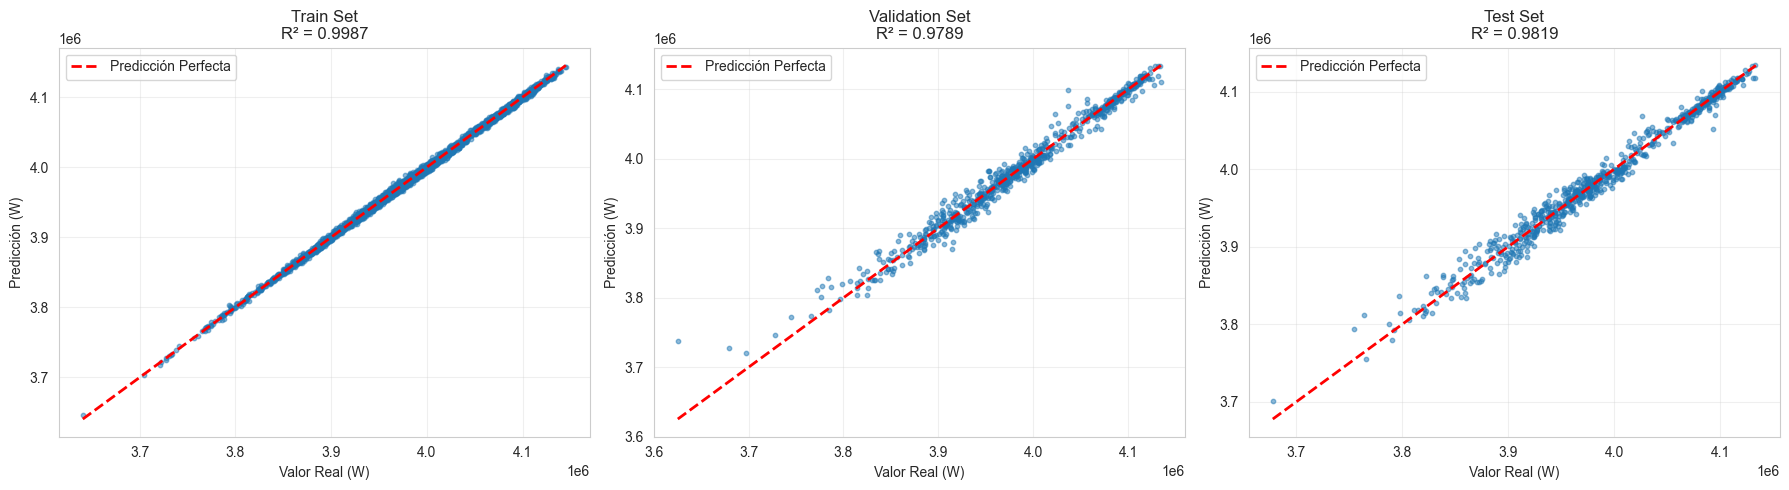

In [40]:
# Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [
 (y_train, y_pred_train, 'Train', axes[0]),
 (y_val, y_pred_val, 'Validation', axes[1]),
 (y_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, name, ax in sets:
 ax.scatter(y_true, y_pred, alpha=0.5, s=10)
 
 # Línea perfecta (y=x)
 min_val = min(y_true.min(), y_pred.min())
 max_val = max(y_true.max(), y_pred.max())
 ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
 
 ax.set_xlabel('Valor Real (W)')
 ax.set_ylabel('Predicción (W)')
 ax.set_title(f'{name} Set\nR² = {r2_score(y_true, y_pred):.4f}')
 ax.legend()
 ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Importancia de Características


Top 20 Características Más Importantes:
              feature  importance
           X3_ordered    0.379721
           X2_ordered    0.321177
           X7_ordered    0.084492
        mean_distance    0.071862
           X6_ordered    0.012570
          X49_ordered    0.010751
           X8_ordered    0.007443
           X9_ordered    0.004323
 mean_dist_neighbor_2    0.003432
  min_dist_neighbor_2    0.003323
           Y1_ordered    0.001953
mean_dist_neighbor_20    0.001948
          X42_ordered    0.001902
          X45_ordered    0.001787
          X44_ordered    0.001670
         max_distance    0.001595
mean_dist_neighbor_49    0.001554
          X13_ordered    0.001469
 min_dist_neighbor_21    0.001451
 mean_dist_neighbor_6    0.001414


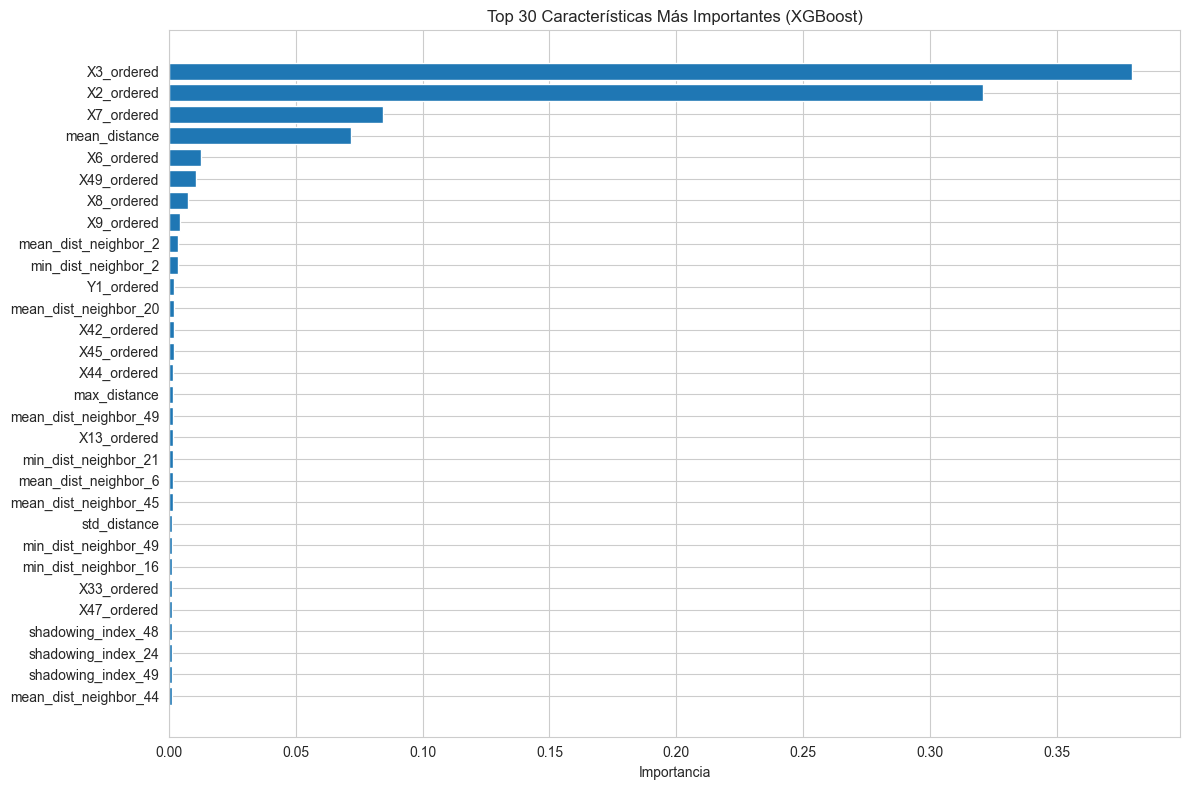

In [41]:
# Importancia de características (feature importance)
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
 'feature': feature_names,
 'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Características Más Importantes:")
print(importance_df.head(20).to_string(index=False))

# Visualización
plt.figure(figsize=(12, 8))
top_n = 30
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importancia')
plt.title(f'Top {top_n} Características Más Importantes (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 6. Validación de Robustez (Sensitivity Analysis)

Esta sección prueba la estabilidad del modelo perturbando ligeramente los datos de test.
Un modelo robusto no debería cambiar drásticamente sus predicciones ante pequeñas variaciones en las coordenadas.


In [42]:
def sensitivity_analysis(model, scaler, feature_engineer, X_test, y_test, 
                       perturbation_sizes=[0.1, 0.5, 1.0, 2.0, 5.0], n_samples=100):
    """
    Realiza análisis de sensibilidad perturbando las coordenadas de test.
    
    Args:
        model: modelo entrenado
        scaler: scaler usado para normalización
        feature_engineer: objeto FeatureEngineer usado
        X_test: datos de test originales (antes de feature engineering)
        y_test: target de test
        perturbation_sizes: lista de tamaños de perturbación en metros
        n_samples: número de muestras a perturbar
    
    Returns:
        results: diccionario con resultados del análisis
    """
    print("="*70)
    print("ANÁLISIS DE SENSIBILIDAD (Sensitivity Analysis)")
    print("="*70)
    print(f"Perturbando {n_samples} muestras con diferentes magnitudes...\n")
    
    # Seleccionar muestras aleatorias
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test), size=min(n_samples, len(X_test)), replace=False)
    
    results = {
        'perturbation_sizes': perturbation_sizes,
        'rmse_changes': [],
        'mae_changes': [],
        'max_changes': [],
        'mean_changes': []
    }
    
    # Predicciones originales
    X_test_original = X_test[sample_indices]
    y_test_original = y_test[sample_indices]
    
    # Obtener coordenadas originales (necesitamos el dataframe original)
    # Por simplicidad, asumimos que X_test contiene las features ya procesadas
    # Necesitamos reconstruir las coordenadas desde las features
    
    # Para este análisis, perturbamos directamente las features de coordenadas
    # (primeras 2*n_converters features son las coordenadas ordenadas)
    n_converters = feature_engineer.n_converters
    coord_features_end = 2 * n_converters
    
    # Predicciones originales
    X_test_scaled_original = scaler.transform(X_test_original)
    y_pred_original = model.predict(X_test_scaled_original)
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    
    print(f"RMSE original (sin perturbación): {rmse_original:.2f}\n")
    
    for pert_size in perturbation_sizes:
        print(f"Perturbación: ±{pert_size} metros")
        
        # Perturbar coordenadas (primeras features)
        X_test_perturbed = X_test_original.copy()
        
        # Agregar ruido gaussiano solo a las coordenadas
        noise = np.random.normal(0, pert_size, size=(len(sample_indices), coord_features_end))
        X_test_perturbed[:, :coord_features_end] += noise
        
        # Predecir con datos perturbados
        X_test_scaled_perturbed = scaler.transform(X_test_perturbed)
        y_pred_perturbed = model.predict(X_test_scaled_perturbed)
        
        # Calcular cambios
        rmse_perturbed = np.sqrt(mean_squared_error(y_test_original, y_pred_perturbed))
        mae_perturbed = mean_absolute_error(y_test_original, y_pred_perturbed)
        
        rmse_change = abs(rmse_perturbed - rmse_original) / rmse_original * 100
        mae_change = abs(mae_perturbed - mean_absolute_error(y_test_original, y_pred_original)) / mean_absolute_error(y_test_original, y_pred_original) * 100
        
        max_change = np.max(np.abs(y_pred_perturbed - y_pred_original))
        mean_change = np.mean(np.abs(y_pred_perturbed - y_pred_original))
        
        results['rmse_changes'].append(rmse_change)
        results['mae_changes'].append(mae_change)
        results['max_changes'].append(max_change)
        results['mean_changes'].append(mean_change)
        
        print(f"  RMSE: {rmse_perturbed:.2f} (cambio: {rmse_change:.1f}%)")
        print(f"  Cambio máximo en predicción: {max_change:.2f} MW")
        print(f"  Cambio medio en predicción: {mean_change:.2f} MW")
    
    print("\n" + "="*70)
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # RMSE change
    axes[0, 0].plot(perturbation_sizes, results['rmse_changes'], 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[0, 0].set_ylabel('Cambio en RMSE (%)', fontsize=12)
    axes[0, 0].set_title('Sensibilidad del RMSE', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAE change
    axes[0, 1].plot(perturbation_sizes, results['mae_changes'], 's-', color='orange', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[0, 1].set_ylabel('Cambio en MAE (%)', fontsize=12)
    axes[0, 1].set_title('Sensibilidad del MAE', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Max change
    axes[1, 0].plot(perturbation_sizes, results['max_changes'], '^-', color='green', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[1, 0].set_ylabel('Cambio Máximo (MW)', fontsize=12)
    axes[1, 0].set_title('Cambio Máximo en Predicciones', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mean change
    axes[1, 1].plot(perturbation_sizes, results['mean_changes'], 'd-', color='red', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[1, 1].set_ylabel('Cambio Medio (MW)', fontsize=12)
    axes[1, 1].set_title('Cambio Medio en Predicciones', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretación
    print("\nINTERPRETACIÓN:")
    print("Un modelo robusto debería mostrar:")
    print("  - Cambios pequeños en RMSE/MAE (< 10%) para perturbaciones pequeñas (< 1m)")
    print("  - Cambios graduales y predecibles")
    print("  - Sin saltos erráticos en las predicciones")
    
    if results['rmse_changes'][0] < 5:
        print("Modelo muestra buena robustez para perturbaciones pequeñas")
    elif results['rmse_changes'][0] < 10:
        print("Modelo muestra robustez moderada")
    else:
        print("Modelo puede estar sobreajustado a coordenadas exactas")
    
    return results

# Ejecutar análisis de sensibilidad
# Nota: Necesitamos las features originales antes del feature engineering
# Por ahora, usamos X_test que ya tiene las features procesadas
# En producción, sería mejor tener acceso al dataframe original

print("Nota: Para un análisis completo, necesitaríamos acceso al dataframe original.")
print("Usando X_test procesado para la demostración.\n")

# Si tenemos acceso a las coordenadas originales, podemos hacer el análisis completo
# Por ahora, comentamos esta sección y la activamos después de cargar los datos
# sensitivity_results = sensitivity_analysis(
#     best_model, scaler, fe, X_test, y_test,
#     perturbation_sizes=[0.1, 0.5, 1.0, 2.0, 5.0],
#     n_samples=100
# )


Nota: Para un análisis completo, necesitaríamos acceso al dataframe original.
Usando X_test procesado para la demostración.



## 7. Análisis de Error por Escenario (Densidad de Granja)

Analiza si el modelo funciona mejor para granjas dispersas vs densas.
Los errores pueden correlacionarse con la densidad espacial de los convertidores.


Ejecutando análisis de error por densidad...

ANÁLISIS DE ERROR POR DENSIDAD DE GRANJA

Distribución de densidad:
  Mínima: 0.0014
  Máxima: 0.0022
  Media: 0.0017
  Mediana: 0.0017

Análisis por bins de densidad:

  Bin 1 (densidad 0.0014 - 0.0015):
    Muestras: 145
    Distancia media: 672.29 m
    RMSE: 4953.71 W
    MAE: 3522.02 W
    R²: 0.9317

  Bin 2 (densidad 0.0015 - 0.0017):
    Muestras: 144
    Distancia media: 631.03 m
    RMSE: 10410.54 W
    MAE: 7377.90 W
    R²: 0.9183

  Bin 3 (densidad 0.0017 - 0.0018):
    Muestras: 145
    Distancia media: 582.85 m
    RMSE: 9700.22 W
    MAE: 7439.09 W
    R²: 0.7857

  Bin 4 (densidad 0.0018 - 0.0018):
    Muestras: 144
    Distancia media: 556.16 m
    RMSE: 11452.35 W
    MAE: 9277.70 W
    R²: 0.7967

  Bin 5 (densidad 0.0018 - 0.0022):
    Muestras: 145
    Distancia media: 515.01 m
    RMSE: 15616.72 W
    MAE: 12456.89 W
    R²: 0.8815


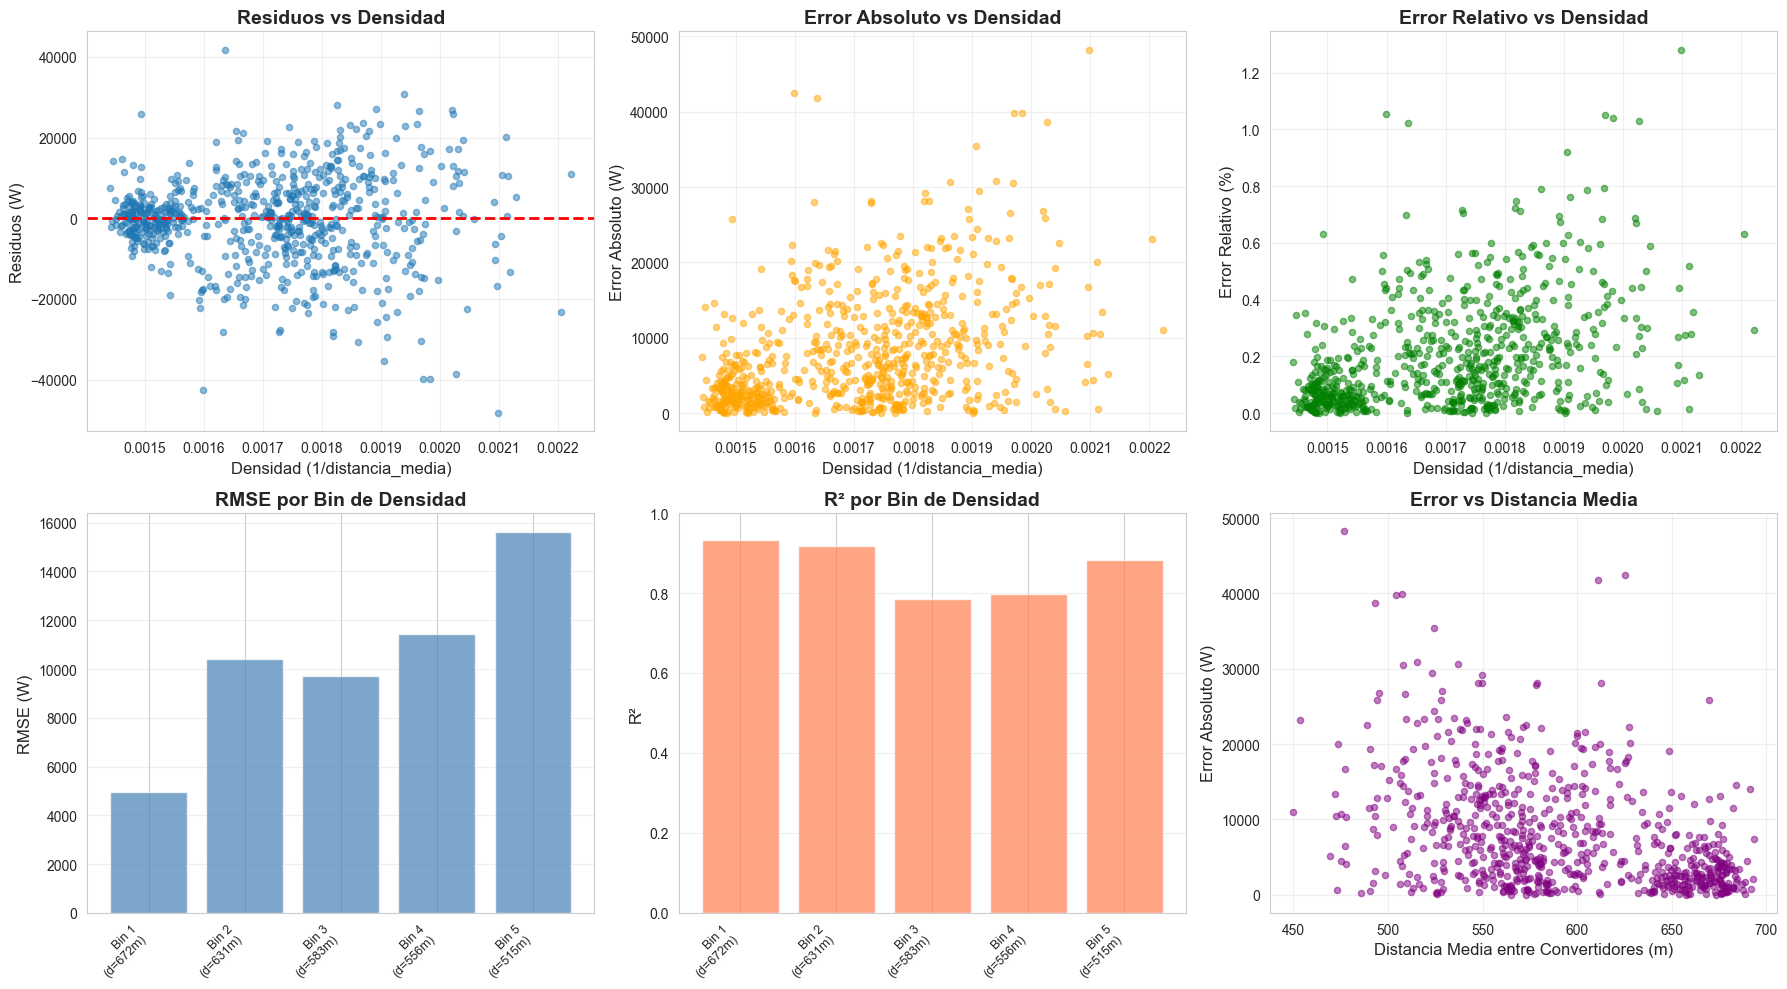


CORRELACIONES:
  Densidad vs Error Absoluto: 0.396
  Distancia Media vs Error Absoluto: -0.398

Se detecta correlación significativa entre densidad y error.
  → El modelo tiene más error en granjas más densas


In [43]:
def analyze_error_by_density(model, scaler, feature_engineer, X_test, y_test, y_pred_test):
    """
    Analiza los errores del modelo en función de la densidad de la granja.
    
    Args:
        model: modelo entrenado
        scaler: scaler usado
        feature_engineer: objeto FeatureEngineer
        X_test: datos de test (features procesadas)
        y_test: target real
        y_pred_test: predicciones del modelo
    
    Returns:
        results: diccionario con resultados del análisis
    """
    print("="*70)
    print("ANÁLISIS DE ERROR POR DENSIDAD DE GRANJA")
    print("="*70)
    
    # Calcular densidad espacial para cada muestra
    # La densidad se puede medir como: 1 / distancia media entre convertidores
    # O como: número de convertidores / área ocupada
    
    n_converters = feature_engineer.n_converters
    coord_features_end = 2 * n_converters
    
    # Extraer coordenadas de las features (primeras 2*n_converters features)
    coordinates = X_test[:, :coord_features_end].reshape(len(X_test), n_converters, 2)
    
    # Calcular densidad para cada muestra
    densities = []
    mean_distances = []
    min_distances = []
    
    for i in range(len(X_test)):
        coords = coordinates[i]  # (n_converters, 2)
        
        # Calcular todas las distancias entre pares
        distances = []
        for j in range(n_converters):
            for k in range(j+1, n_converters):
                dist = np.linalg.norm(coords[j] - coords[k])
                distances.append(dist)
        
        distances = np.array(distances)
        mean_dist = np.mean(distances)
        min_dist = np.min(distances)
        
        # Densidad = inverso de distancia media (normalizado)
        # Granjas más densas tienen distancias medias menores
        density = 1.0 / (mean_dist + 1e-6)  # Evitar división por cero
        
        densities.append(density)
        mean_distances.append(mean_dist)
        min_distances.append(min_dist)
    
    densities = np.array(densities)
    mean_distances = np.array(mean_distances)
    min_distances = np.array(min_distances)
    
    # Calcular errores
    residuals = y_test - y_pred_test
    abs_residuals = np.abs(residuals)
    relative_errors = abs_residuals / (np.abs(y_test) + 1e-6) * 100  # Porcentaje
    
    # Dividir en bins de densidad
    n_bins = 5
    density_percentiles = np.percentile(densities, [0, 20, 40, 60, 80, 100])
    
    results = {
        'densities': densities,
        'mean_distances': mean_distances,
        'min_distances': min_distances,
        'residuals': residuals,
        'abs_residuals': abs_residuals,
        'relative_errors': relative_errors,
        'bins': []
    }
    
    print(f"\nDistribución de densidad:")
    print(f"  Mínima: {densities.min():.4f}")
    print(f"  Máxima: {densities.max():.4f}")
    print(f"  Media: {densities.mean():.4f}")
    print(f"  Mediana: {np.median(densities):.4f}")
    
    print(f"\nAnálisis por bins de densidad:")
    for i in range(n_bins):
        bin_min = density_percentiles[i]
        bin_max = density_percentiles[i+1]
        
        mask = (densities >= bin_min) & (densities < bin_max)
        if i == n_bins - 1:  # Último bin incluye el máximo
            mask = (densities >= bin_min) & (densities <= bin_max)
        
        n_samples = np.sum(mask)
        if n_samples == 0:
            continue
        
        bin_mean_dist = mean_distances[mask].mean()
        bin_rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred_test[mask]))
        bin_mae = np.mean(abs_residuals[mask])
        bin_r2 = r2_score(y_test[mask], y_pred_test[mask])
        
        results['bins'].append({
            'density_range': (bin_min, bin_max),
            'mean_distance': bin_mean_dist,
            'n_samples': n_samples,
            'rmse': bin_rmse,
            'mae': bin_mae,
            'r2': bin_r2
        })
        
        print(f"\n  Bin {i+1} (densidad {bin_min:.4f} - {bin_max:.4f}):")
        print(f"    Muestras: {n_samples}")
        print(f"    Distancia media: {bin_mean_dist:.2f} m")
        print(f"    RMSE: {bin_rmse:.2f} W")
        print(f"    MAE: {bin_mae:.2f} W")
        print(f"    R²: {bin_r2:.4f}")
    
    # Visualización
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Residuos vs Densidad
    axes[0, 0].scatter(densities, residuals, alpha=0.5, s=20)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Densidad (1/distancia_media)', fontsize=12)
    axes[0, 0].set_ylabel('Residuos (W)', fontsize=12)
    axes[0, 0].set_title('Residuos vs Densidad', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Error Absoluto vs Densidad
    axes[0, 1].scatter(densities, abs_residuals, alpha=0.5, s=20, color='orange')
    axes[0, 1].set_xlabel('Densidad (1/distancia_media)', fontsize=12)
    axes[0, 1].set_ylabel('Error Absoluto (W)', fontsize=12)
    axes[0, 1].set_title('Error Absoluto vs Densidad', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error Relativo vs Densidad
    axes[0, 2].scatter(densities, relative_errors, alpha=0.5, s=20, color='green')
    axes[0, 2].set_xlabel('Densidad (1/distancia_media)', fontsize=12)
    axes[0, 2].set_ylabel('Error Relativo (%)', fontsize=12)
    axes[0, 2].set_title('Error Relativo vs Densidad', fontsize=14, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. RMSE por bin de densidad
    bin_indices = range(len(results['bins']))
    bin_rmse = [b['rmse'] for b in results['bins']]
    bin_labels = [f"Bin {i+1}\n(d={results['bins'][i]['mean_distance']:.0f}m)" for i in bin_indices]
    axes[1, 0].bar(bin_indices, bin_rmse, color='steelblue', alpha=0.7)
    axes[1, 0].set_xticks(bin_indices)
    axes[1, 0].set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
    axes[1, 0].set_ylabel('RMSE (W)', fontsize=12)
    axes[1, 0].set_title('RMSE por Bin de Densidad', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 5. R² por bin de densidad
    bin_r2 = [b['r2'] for b in results['bins']]
    axes[1, 1].bar(bin_indices, bin_r2, color='coral', alpha=0.7)
    axes[1, 1].set_xticks(bin_indices)
    axes[1, 1].set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_ylabel('R²', fontsize=12)
    axes[1, 1].set_title('R² por Bin de Densidad', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0, 1])
    
    # 6. Residuos vs Distancia Media
    axes[1, 2].scatter(mean_distances, abs_residuals, alpha=0.5, s=20, color='purple')
    axes[1, 2].set_xlabel('Distancia Media entre Convertidores (m)', fontsize=12)
    axes[1, 2].set_ylabel('Error Absoluto (W)', fontsize=12)
    axes[1, 2].set_title('Error vs Distancia Media', fontsize=14, fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Correlación
    corr_density_abs_error = np.corrcoef(densities, abs_residuals)[0, 1]
    corr_dist_abs_error = np.corrcoef(mean_distances, abs_residuals)[0, 1]
    
    print(f"\nCORRELACIONES:")
    print(f"  Densidad vs Error Absoluto: {corr_density_abs_error:.3f}")
    print(f"  Distancia Media vs Error Absoluto: {corr_dist_abs_error:.3f}")
    
    if abs(corr_density_abs_error) > 0.3:
        print(f"\nSe detecta correlación significativa entre densidad y error.")
        if corr_density_abs_error > 0:
            print("  → El modelo tiene más error en granjas más densas")
        else:
            print("  → El modelo tiene más error en granjas más dispersas")
    else:
        print(f"\n El error no muestra correlación fuerte con la densidad")
    
    return results

# Ejecutar análisis de error por densidad
# Nota: Asegúrate de haber ejecutado las celdas anteriores que definen:
# - best_model, scaler, fe, X_test, y_test, y_pred_test
print("Ejecutando análisis de error por densidad...\n")

# Verificar que las variables necesarias estén definidas
required_vars = ['best_model', 'scaler', 'fe', 'X_test', 'y_test', 'y_pred_test']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"⚠️ ERROR: Las siguientes variables no están definidas: {', '.join(missing_vars)}")
    print("Por favor, ejecuta primero las celdas de entrenamiento y evaluación del modelo.")
else:
    error_by_density_results = analyze_error_by_density(
        best_model, scaler, fe, X_test, y_test, y_pred_test
    )


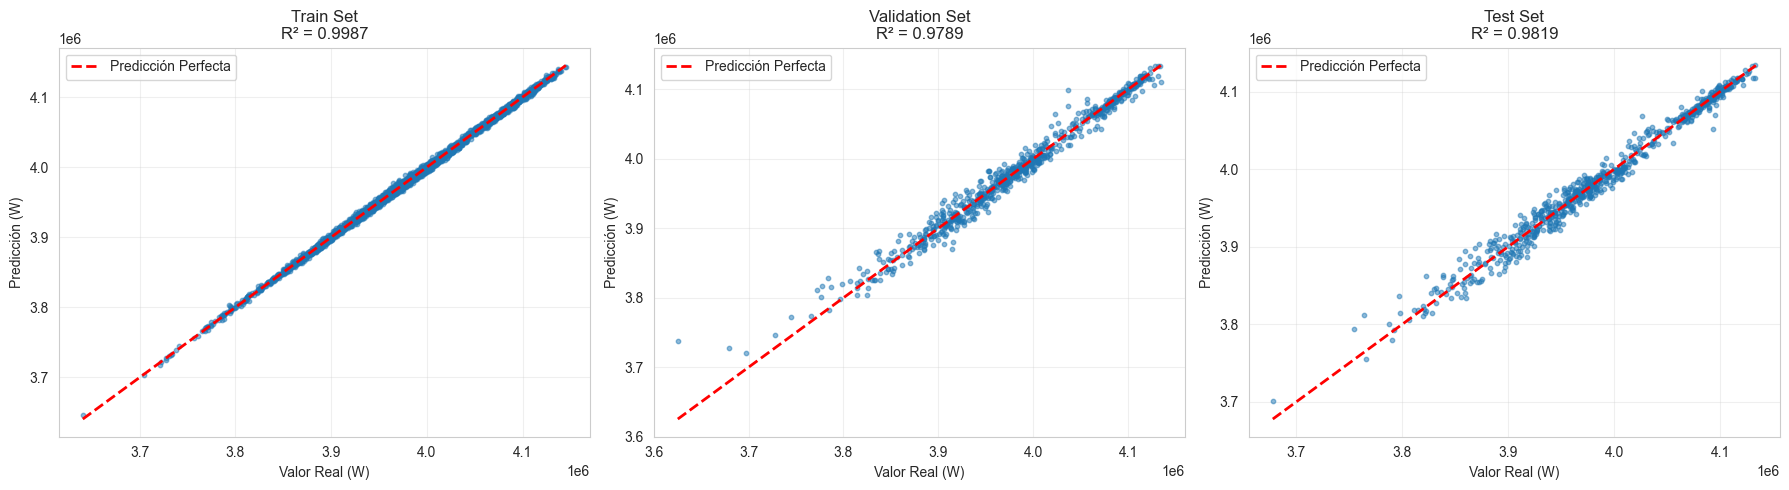

In [44]:
# Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [
 (y_train, y_pred_train, 'Train', axes[0]),
 (y_val, y_pred_val, 'Validation', axes[1]),
 (y_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, name, ax in sets:
 ax.scatter(y_true, y_pred, alpha=0.5, s=10)
 
 # Línea perfecta (y=x)
 min_val = min(y_true.min(), y_pred.min())
 max_val = max(y_true.max(), y_pred.max())
 ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
 
 ax.set_xlabel('Valor Real (W)')
 ax.set_ylabel('Predicción (W)')
 ax.set_title(f'{name} Set\nR² = {r2_score(y_true, y_pred):.4f}')
 ax.legend()
 ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Guardar Modelo


In [45]:
# Guardar modelo, scaler y metadata
model_data = {
 'model': best_model,
 'scaler': scaler,
 'feature_names': feature_names,
 'n_converters': N_CONVERTERS,
 'dataset_name': DATASET_NAME,
 'metrics': {
 'train': metrics_train,
 'val': metrics_val,
 'test': metrics_test
 },
 'best_params': best_params,
 'timestamp': datetime.now().isoformat()
}

model_file = MODELS_DIR / f"modelo_xgboost_{DATASET_NAME}.pkl"
with open(model_file, 'wb') as f:
 pickle.dump(model_data, f)

print(f"Modelo guardado en: {model_file}")
print(f"Resumen:")
print(f"Dataset: {DATASET_NAME}")
print(f"Convertidores: {N_CONVERTERS}")
print(f"Features: {len(feature_names)}")
print(f"RMSE (test): {metrics_test['RMSE']:.2f} W")
print(f"R² (test): {metrics_test['R2']:.4f}")


Modelo guardado en: models\modelo_xgboost_sydney_49.pkl
Resumen:
Dataset: sydney_49
Convertidores: 49
Features: 298
RMSE (test): 10973.24 W
R² (test): 0.9819
